# Imports

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch.optim.lr_scheduler as lr_scheduler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2


# Directiry Setup

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Mega/Master Studies/Studying/Introduction to Deep Learning (18786)/Mini project/Miniproject')

Mounted at /content/drive


# Load Data

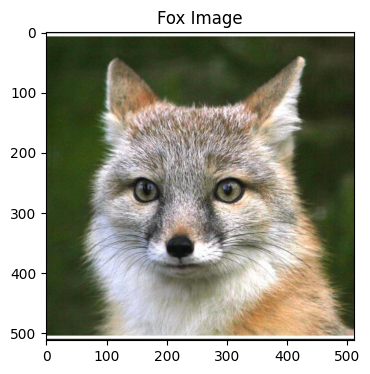

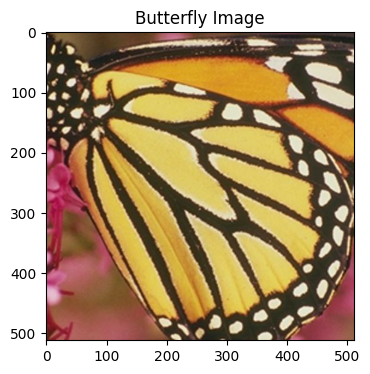

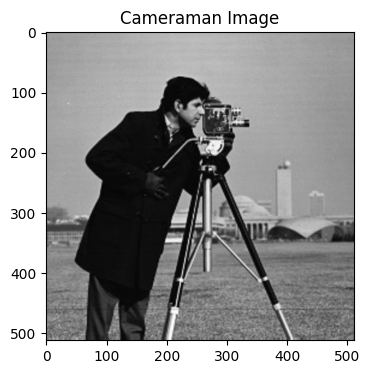

In [3]:
image_fox = plt.imread('data/image/fox.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Fox Image')
plt.show()

image_butterfly = plt.imread('data/image/butterfly.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_butterfly)
plt.title('Butterfly Image')
plt.show()

image_man = plt.imread('data/image/cameraman.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Cameraman Image')
plt.show()

# Cameraman Image

## Prepare data

In [4]:
## Original Input:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)


## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels
y = image_man.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

In [5]:
y.size()

torch.Size([262144, 3])

## Define network

In [6]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [7]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

## Train the model
num_epochs = 100
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-7-d4fb89c03c7d>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-7-d4fb89c03c7d>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Epoch [1/100], Loss: 0.0602, PSNR: 12.2046, SSIM: 0.6129
Epoch [2/100], Loss: 0.1141, PSNR: 9.4253, SSIM: 0.4717
Epoch [3/100], Loss: 0.0591, PSNR: 12.2876, SSIM: 0.6078
Epoch [4/100], Loss: 0.0595, PSNR: 12.2530, SSIM: 0.6141
Epoch [5/100], Loss: 0.0596, PSNR: 12.2455, SSIM: 0.6144
Epoch [6/100], Loss: 0.0596, PSNR: 12.2482, SSIM: 0.6143
Epoch [7/100], Loss: 0.0595, PSNR: 12.2542, SSIM: 0.6141
Epoch [8/100], Loss: 0.0594, PSNR: 12.2625, SSIM: 0.6138
Epoch [9/100], Loss: 0.0593, PSNR: 12.2729, SSIM: 0.6134
Epoch [10/100], Loss: 0.0591, PSNR: 12.2841, SSIM: 0.6129
Epoch [11/100], Loss: 0.0590, PSNR: 12.2952, SSIM: 0.6123
Epoch [12/100], Loss: 0.0588, PSNR: 12.3052, SSIM: 0.6116
Epoch [13/100], Loss: 0.0587, PSNR: 12.3142, SSIM: 0.6110
Epoch [14/100], Loss: 0.0586, PSNR: 12.3216, SSIM: 0.6104
Epoch [15/100], Loss: 0.0585, PSNR: 12.3270, SSIM: 0.6099
Epoch [16/100], Loss: 0.0585, PSNR: 12.3318, SSIM: 0.6093
Epoch [17/100], Loss: 0.0584, PSNR: 12.3383, SSIM: 0.6090
Epoch [18/100], Loss: 0.

## Show Results

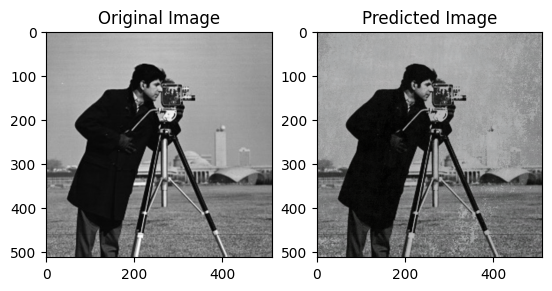

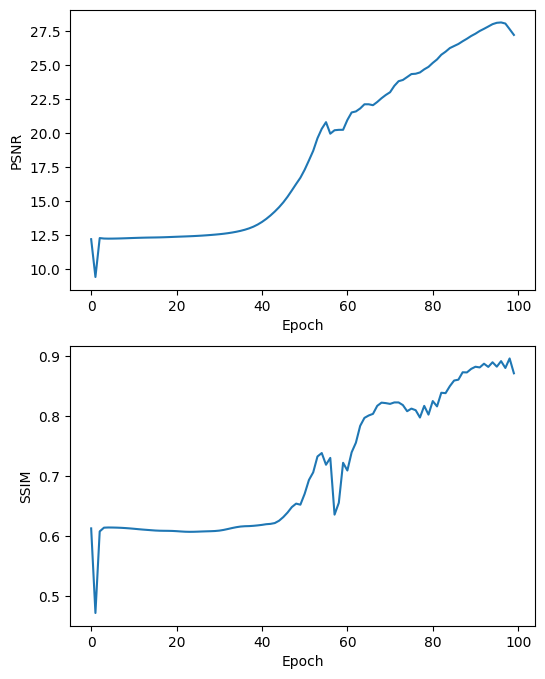

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# Butterfly Image

## Prepare data

In [54]:
## Original Input:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)


## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels
y = image_butterfly.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [55]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [56]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


## Train the model
num_epochs = 300
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # prepare for next epoch:
  # scheduler.step()
  # before_lr = optimizer.param_groups[0]["lr"]

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-56-e960ba7284a5>:41: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-56-e960ba7284a5>:42: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)


Epoch [1/300], Loss: 0.0790, PSNR: 12.2267, SSIM: 0.6116
Epoch [2/300], Loss: 0.0771, PSNR: 12.2380, SSIM: 0.6114
Epoch [3/300], Loss: 0.0753, PSNR: 12.2426, SSIM: 0.6110
Epoch [4/300], Loss: 0.0737, PSNR: 12.2410, SSIM: 0.6105
Epoch [5/300], Loss: 0.0722, PSNR: 12.2332, SSIM: 0.6097
Epoch [6/300], Loss: 0.0707, PSNR: 12.2188, SSIM: 0.6088
Epoch [7/300], Loss: 0.0693, PSNR: 12.1970, SSIM: 0.6077
Epoch [8/300], Loss: 0.0679, PSNR: 12.1669, SSIM: 0.6063
Epoch [9/300], Loss: 0.0666, PSNR: 12.1273, SSIM: 0.6048
Epoch [10/300], Loss: 0.0653, PSNR: 12.0772, SSIM: 0.6029
Epoch [11/300], Loss: 0.0642, PSNR: 12.0154, SSIM: 0.6008
Epoch [12/300], Loss: 0.0630, PSNR: 11.9412, SSIM: 0.5984
Epoch [13/300], Loss: 0.0621, PSNR: 11.8541, SSIM: 0.5956
Epoch [14/300], Loss: 0.0612, PSNR: 11.7542, SSIM: 0.5926
Epoch [15/300], Loss: 0.0605, PSNR: 11.6426, SSIM: 0.5893
Epoch [16/300], Loss: 0.0600, PSNR: 11.5214, SSIM: 0.5858
Epoch [17/300], Loss: 0.0596, PSNR: 11.3939, SSIM: 0.5822
Epoch [18/300], Loss: 0

## Show Results

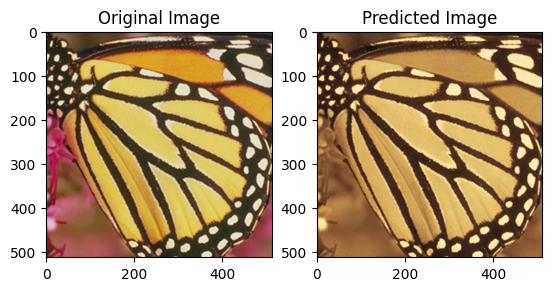

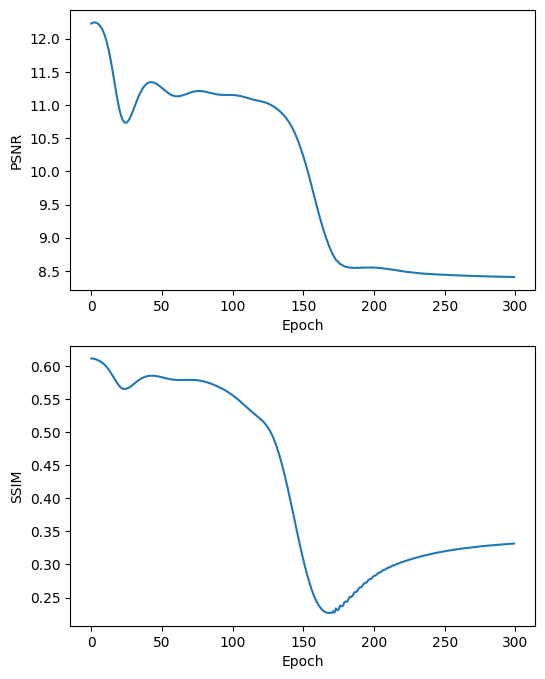

In [57]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_butterfly)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# Fox Image

## Prepare data

In [59]:
## Original Input:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)


## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels
y = image_fox.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

In [44]:
X.dtype

torch.float32

## Define network

In [60]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [61]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

## Train the model
num_epochs = 300
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-61-f92771f90484>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-61-f92771f90484>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)


Epoch [1/300], Loss: 0.0813, PSNR: 12.1707, SSIM: 0.6127
Epoch [2/300], Loss: 0.0804, PSNR: 12.2001, SSIM: 0.6121
Epoch [3/300], Loss: 0.0797, PSNR: 12.2218, SSIM: 0.6113
Epoch [4/300], Loss: 0.0791, PSNR: 12.2361, SSIM: 0.6104
Epoch [5/300], Loss: 0.0786, PSNR: 12.2432, SSIM: 0.6093
Epoch [6/300], Loss: 0.0782, PSNR: 12.2431, SSIM: 0.6080
Epoch [7/300], Loss: 0.0778, PSNR: 12.2359, SSIM: 0.6065
Epoch [8/300], Loss: 0.0776, PSNR: 12.2212, SSIM: 0.6049
Epoch [9/300], Loss: 0.0774, PSNR: 12.1994, SSIM: 0.6031
Epoch [10/300], Loss: 0.0774, PSNR: 12.1716, SSIM: 0.6012
Epoch [11/300], Loss: 0.0774, PSNR: 12.1403, SSIM: 0.5994
Epoch [12/300], Loss: 0.0775, PSNR: 12.1099, SSIM: 0.5979
Epoch [13/300], Loss: 0.0776, PSNR: 12.0851, SSIM: 0.5968
Epoch [14/300], Loss: 0.0776, PSNR: 12.0694, SSIM: 0.5962
Epoch [15/300], Loss: 0.0776, PSNR: 12.0636, SSIM: 0.5962
Epoch [16/300], Loss: 0.0776, PSNR: 12.0665, SSIM: 0.5966
Epoch [17/300], Loss: 0.0775, PSNR: 12.0760, SSIM: 0.5973
Epoch [18/300], Loss: 0

## Show Results

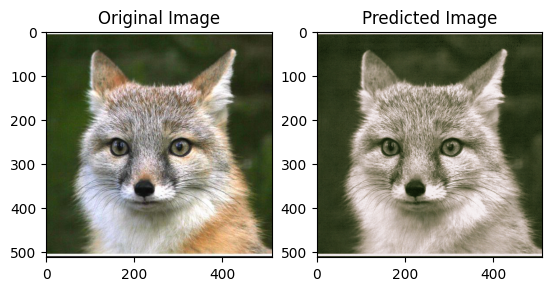

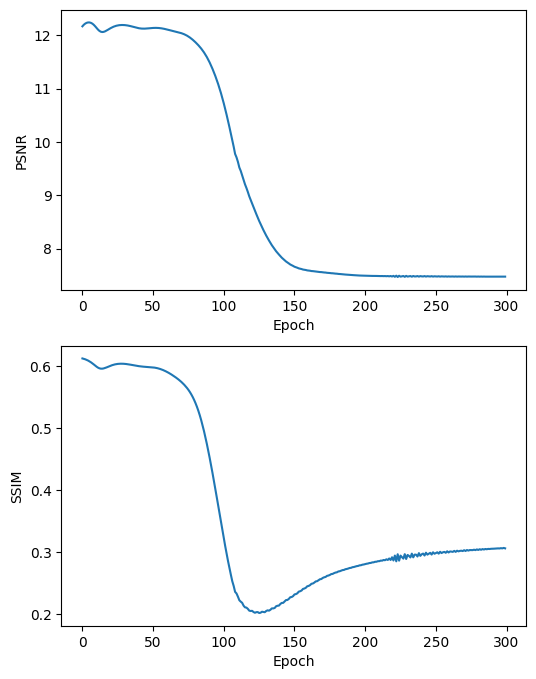

In [62]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_fox)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()